## EEP 502: Analytical Methods for Electrical Engineering
    
# Final project
## Due December 14, 2024 at 11:59 PM
Copyright &copy; 2024, University of Washington

<hr>

**Instructions**: Choose **<u>one</u>** of the following problems. Solve the problem and then write up your solution in a stand-alone Jupyter Notebook. Your notebook should have the following elements:

- Problem statement
- Mathematical description of the solution
- Executable, commented, clear code

You will be graded on how well your notebook reads like a nicely formated, well written report. You must:

- Write mathematical descriptions using complete sentences, paragraphs, and LaTeX formulas.
- Comment your code as necessary, with a description of what each function does, and all major steps.
- Label plots axes, use legends, and use plot titles.
- Before submitting a notebook, choose Kernel -> Restart and Run All to make sure your notebook runs when the cells are evaluated in order.

<span style="color: red'">
Although you may discuss the project with others, you must turn in your own, original work.
</span>


In [1]:
import networkx as nx
import math
import scipy
import scipy.integrate as spi
import numpy as np
import sympy as sm
sm.init_printing(use_latex='mathjax')
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib inline

# Differential Equations for Neural Networks

The computational neural networks we have been studying are quite far from what is happening in biology. A slightly more realistic model is to admit that each neuron $i$ in a network has a time varying firing rate $x_i$, for $i$ equal $1$ to $n$. We let $W \in \mathbb{R}^{n \times n}$ be weight matrix, and $b \in \mathbb{R}^n$. The dynamics of such a neural network are

$$
\dot x_i = g \left (
\sum_{j=1}^n w_{i,j} x_j + b_i
\right )
$$

where is the nonlinearity

$$
g(x) = \frac{1}{1+e^{-x}} - \frac{1}{2} .
$$

*a)* Show through simulation that the matrix

$$
W = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

with $b = 0$ results in oscillations. This is called a ring oscillator. Draw a graph representation of it. Now show through simulation that a ring of $n$ neurons so arranged oscillates when $n$ is odd, but not when it is even.

*b)* Define $W$ and $b$ so that the resulting network is bistable. That is, when one neuron is on in steady state, another is off, and *vice versa*. Simulate the system with different initial conditions. Draw a graph representation of your network.

*c)* Build a network that contains two subnetworks that oscillate, that are connected in such a way that if one subnetwork oscillates, it prevents the other from oscillating, and *vice versa*. Simulate the system with different initial conditions to show the desired behavior. Draw a graph representation of your network.

*d)* Define $W \in \mathbb{R}^{n \times n}$ and $b \in \mathbb{R}^n$ with $n = 50$ to be a random neural network.

Given a number $p \in [0,1]$, define a random matrix $A$ as follows. For each $i,j$, choose $r \in [0,1]$ randomly. Then put

$$
A_{i,j} = \left \{
\begin{array}{ll}
1 & \mathrm{if} & r \leq \frac{p}{2} \\
-1 & \mathrm{if} & \frac{p}{2} < r \leq p \\
0 & \mathrm{otherwise}.
\end{array}
\right .
$$

Then put

$$
W = A - I
$$

where $I$ is the identity matrix. Through simulations with $n=20$, explain the various behaviors you can get with various values of $p$.

Computational neural networks, used in machine learning and deep learning models, are inspired by neurons in biology. Artificial neural networks, similar to biological neural networks, use a node which peforms a linear regression based on the weighted inputs to the node and a bias to shift the activation threshold of the node. <br> <br>
At a high-level, the dynamics of a computational neural network node can be modeled as,
$$x_i = \sum_{j=1}^n w_{i,j} x_j + b_i$$  
Here, $x_i$ indicates whether a node fired, which occurs if the output exceeds a threshold value. The threshold value is solved by summing all time varying firing rates ($x_j$) from node 1 to $n$ in the network, multiplied by their respective weights ($w_i,j$) in the weight matrix $W \in \mathbb{R}^{nxn}$, then adding the bias of the neuron ($b_i$). Each weight indicates the significance of the input to neuron $x_i$. <br><br>
Although the computational neural network model is similar to biological neural networks, neurons in biology have a time varying firing rate. The following formula can be used to solve for the nonlinear firing rate of each neuron over time.
$$g(x) = \frac{1}{1+e^{-x}}-\frac{1}{2}$$
The computational neural network formula above can be used as an input to our nonlinearity function.

The problem sets required in this project investigate and simulate the latent behaviors of neural networks as a function of their initial conditions, assumptions, and network configuration as a function of time. To emphasize, a more accurate biological model of neurons uses time as component and without it the interesting behavior investigated would not occur.

At a high-level, this project investigates four behaviors by using differential equations for neural networks:
1. $\textbf{Ring Oscillators}$ <br>
Demonstrate that cyclically connected neural networks with an even number of neurons inhibits neuron firing, while odd number neural networks results in oscillatory behavior. <br>
Simulation should use $b = 0$ matrix, 
$$
W = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

2. $\textbf{Bistable Switches}$ <br>
Determine a $W$ and $b$ that result in a bistable network across initial conditions.

3. $\textbf{Inhibited Neuron Competing Oscillators}$ <br>
Build two subnetworks that oscillate, where when one network oscillates it inhibits the oscillation of the second subnetwork.

4. $\textbf{Sparse and Dense Neural Networks}$ <br>
Randomly generate a neural network, starting from a sparse neural network to a dense neural network. <br>
Generate the n-size weight matrix with the following random weight generation formula, <br>
Given a number $p \in [0,1]$, define a random matrix $A$ as follows. For each $i,j$, choose $r \in [0,1]$ randomly. Then put
$$
A_{i,j} = \left \{
\begin{array}{ll}
1 & \mathrm{if} & r \leq \frac{p}{2} \\
-1 & \mathrm{if} & \frac{p}{2} < r \leq p \\
0 & \mathrm{otherwise}.
\end{array}
\right .
$$
Then put
$$
W = A - I
$$ 

As the firing rate is a derivative with respect to time and no other factor, the nonlinearity equation for each neuron can be solved as an ordinary differential equation. Better, since neurons are typically modelled as one element of a neural network, the whole neural network lends itself to be treated as a system of ordinary differential equations (ODEs). Assuming the neural network is a system of ODEs, then according the Existence and Uniqueness Theorem there will be a solution, and the solution will be unique for each neuron in the network. Knowing that each neuron has a solution, the behavior can then be modelled at any given point if an initial condition is provided.

Before investigating the solution set for the problems, I wrote out python defintions to model the nonlinear neuron firing rate as a function of time.
1. $\textbf{nonlinearity\_func()}$ <br>
Created a model of the nonlinearity function that represents the neuron's firing rate. This allows the function to be swapped with other models to improve the neuron firing rate model. The function returns the firing rate of an individual neuron.
2. $\textbf{neuron\_firing\_rate\_func()}$ <br>
Created a model of the neuron firing rate for all neurons in the next layer of the neural network, which calls the nonlinear function model $g(x)$ and provides a value $x$. The function inputs are a weight matrix $W$, the neuron firing rates for all the neurons in the current layer of the neural network, and an array of biases $b_i$ for all the neurons in the network. <br>
The function takes the dot product of the weight matrix $W$ and the vector of neuron firing rates from neurons $x_j$ into neuron $x_i$, then adds the bias of neuron $x_i$ for all neurons in the neural network. <br> It is assumed that the weight matrix $W$ is of size $nxn$, the neuron firing rate vector is $n$ wide, and the bias vector is $n$ wide. Otherwise, the matrix multiplication and addition could not work.
3. $\textbf{neuron\_ode()}$ <br>
Finally, I used an ODE solver from the scipy library, the solve_ivp function, to evaluate the firing rate of all the neurons in the neural network as a function of time given a set of initial conditions. <br>
The initial condition vector is expected to be $n$ wide as well, since it represents the initial conditions of all the neurons in the network.
Following the scipy documentation, I used the default ODE solver method RK45, Runge-Kutta method of order 5(4). 

A set of python definitions were written to assist with graphing the networkx representations of each neural network <br>
1. $\textbf{gen\_nn\_nodes()}$ <br>
Adds numbered nodes to the networkx graph to represent neurons in the system. The number of nodes is based off the depth of the bias vector.
2. $\textbf{gen\_nn\_edges()}$ <br>
Adds edges and their respective weights to the networkx graph to represent the strength of neuron inputs in the system. The edges connections and their weights is based off the weight matrix.
3. $\textbf{draw\_nn()}$ <br>
Takes the networkx graph variable and draws out the graph with appropriate edge names and layout pattern.

Final set of python definitions are helper functions that were used in this project.
1. $\textbf{gen\_initial\_conditions\_array()}$ <br>
Generates random initial conditions to be used by the solve_ivp SciPy function. Size of the initial conditiosn vector is determined by the number of neurons specified for the neural network.
2. $\textbf{gen\_rand\_weight()}$ <br>
Function takes in a value p which is between [0,1], compares it against a random number between [0,1] and outputs 1,-1, or 0 based on the comparison result
3. $\textbf{gen\_rand\_weight\_matrix()}$ <br>
Function generates a random weight matrix of size $nxn$.
4. $\textbf{sub\_identity\_matrix()}$ <br>
Subtract the identity matrix fron the random weight matrix to make an offical weight matrix

In [2]:
def nonlinearity_func(x):
    """Model of nonlinearity function that represents the time varying component of a neuron's firing rate
    

    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | x                             | Summed neuron inputs and activiation bias                                                                                         |
    | output    | g_x                           | Neuron firing output                                                                                                              |


    No Exception Handling Provided
    """

    return ((1/(1+np.exp(-x))) - (1/2))

In [3]:
def neuron_firing_rate_func(    t,
                                weight_matrix_i,
                                neuron_firing_rate_vector_i,
                                neuron_bias_i
                                ):
    """Function sums the weighted inputs from all the neurons in the neural network into neuron $i$ and adds an activation threshold bias to change the firing threshold of neuron $i$.
       
    
    Function feeds the weighted neuron input + activation threshold bias into the nonlinearity function to model the firing rate of neuron $i$ as a function of time. 


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | t                             | time variable. time component MUST be first varible due to solve_ivp function requirements                                        |
    | input     | weight_matrix_i               | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$            |
    | input     | neuron_firing_rate_vector_i   | Vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network.                   |
    | input     | neuron_bias_i                 | Real number that adjusts neuron $i$'s activation threshold                                                                        |
    | output    | nonlinearity_func             | Real number that models firing rate of neuron $i$ in a neural network. Refers to g(x) nonlinearity equation                       |


    No Exception Handling Provided
    """
    # Calculate the weighted sum of neuron firing rates into neuron $i$
    x = np.dot(weight_matrix_i,neuron_firing_rate_vector_i) + neuron_bias_i

    # Nonlinearity function g(x) models the activation of neuron x_i
    return nonlinearity_func(x)

In [4]:
def neuron_ode( weight_matrix_i,
                init_neuron_firing_rate_vector_i,
                time_steps_i,
                neuron_bias_i,    
                t_eval_i
                ):
    """Function uses an ODE solver to calculate the activation rate for each neuron in the neural network as a function of time


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                                                                                               |
    | -         | -                                 | -                                                                                                                                                                                                                         |
    | input     | weight_matrix_i                   | Matrix of real numbers (size nxn) that defines the strength (weight) of connections between neurons $j$ and neuron $i$                                                                                                    |
    | input     | init_neuron_firing_rate_vector_i  | Initial vector of real numbers, of size $n$ neurons, that models firing rate for each neuron $j$ in the neural network. The ODE solver will calculate firing rates as a function of time but requires an initial state    |
    | input     | time_steps_i                      | List that contains interval of integration (t0, tf). The ODE solver starts with t=t0 and integrates until it reaches t=tf. Both t0 and tf must be floats or values interpretable by the float conversion function.        |
    | input     | neuron_bias_i                     | Real number that adjusts neuron $i$'s activation threshold                                                                                                                                                                |
    | input     | t_eval_i                          | Times steps which to store the evaluated solution, must be sorted and lie within time_steps_i. If None (default), use points selected by the ODE solver.                                                                  |
    | output    | neuron_activation_rates.t         | Array of real numbers returned by the ODE solver that contains the evaluation times t, constrained by t_eval_i                                                                                                            |
    | output    | neuron_activation_rates.y         | Array of real numbers returned by the ODE solver that contains the evaluated values y for each time interval t. Total y is constrained by t_eval_i                                                                        |

    
    No Exception Handling Provided
    """

    # Use scipy solve_ivp to solve ODE equations. 
    # Currently unsure of which ODE method to use, so following scipy documentation I will use the default method, RK45, since it returns reasonable values
    neuron_activation_rates =   spi.solve_ivp(  lambda t,x : neuron_firing_rate_func(t,weight_matrix_i,x,neuron_bias_i),
                                                time_steps_i,
                                                init_neuron_firing_rate_vector_i,
                                                "RK45",
                                                t_eval_i
                                                )
    return neuron_activation_rates.t,neuron_activation_rates.y

In [5]:
def gen_nn_nodes(num_biases_i,G_i):
    """Function generates the nodes of the neural network based on the depth of activation threshold bias vector $b$.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | num_biases_i                  | Number of biases is used to determine number of nodes (neurons) to add to the networkx graph                                      |
    | output    | G_i                           | Networkx graph output, now with nodes                                                                                             |


    No Exception Handling Provided
    """

    # start node count from 1 rather than zero, because it matches the legend in the neuron firing graphs
    for i in range(1,len(num_biases_i)+1):
        G_i.add_node(i)

    return G_i

In [6]:
def gen_nn_edges(adjacency_matrix_i,G_i):
    """Function generates the edges of the neural network based on the weight matrix $W$ of the network.


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | adjacency_matrix_i            | The weight matrix is the adjacency matrix of the neural network, which describes the edges of the graph                           |
    | output    | G_i                           | Networkx graph output, now with edges                                                                                             |


    No Exception Handling Provided
    """
    
    dimensions = adjacency_matrix_i.shape
    rows,columns = dimensions

    for i in range(1,rows+1):
        for j in range(1,columns+1):
            if (adjacency_matrix_i[i-1,j-1] != 0):
                G_i.add_edge(i,j,weight=adjacency_matrix_i[i-1,j-1])

    return G_i

In [7]:
def draw_nn(G_i,ax_i):
    """Function draws the networkx neural network graph. 


    Interface Control Document (ICD)
    | I/O       | Signal Name                   | Description                                                                                                                       |
    | -         | -                             | -                                                                                                                                 |
    | input     | G_i                           | Networkx graph of the neural network that will be drawn                                                                           |
    | input     | ax_i                          | Graph plot that the networkx graph will be drawn in                                                                               |


    No Exception Handling Provided
    """
    # Draw neural network
    nx.draw(G_i,
            ax=ax_i,
            pos=nx.circular_layout(G_i),
            with_labels=True,
            node_color='#444444',
            font_color="white")
    nx.draw_networkx_edge_labels(G_i, 
                                pos=nx.circular_layout(G_i), 
                                edge_labels=nx.get_edge_attributes(G_i, "weight"))

In [8]:
def gen_initial_conditions_array(iterations_i,num_neurons_i):
    """Create multiple initial condition vectors to feed into neuron ODE function


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                   |
    | -         | -                                 | -                                                                                                                             |
    | input     | iterations_i                      | Determines the number of initial condition vectors to create                                                                  |
    | input     | num_neurons_i                     | Determines the number of neurons in each initial condition vector                                                             |
    | output    | init_neuron_firing_rate_vector_o  | The array of initial condition vectors to be used by the ODE solver                                                           |


    No Exception Handling Provided
    """
    init_neuron_firing_rate_vector_o = []
    for iter in range(iterations_i):
        # Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
        # This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
        # The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
        # Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
        init_neuron_firing_rate = np.array([random.uniform(0,13) for i in range(num_neurons_i)]).reshape(num_neurons_i,) 
        init_neuron_firing_rate_vector_o.append(init_neuron_firing_rate)
    return init_neuron_firing_rate_vector_o

In [9]:
def gen_rand_weight(p_i,lower_bound_i,upper_bound_i):
    """Function takes in a value p which is between [0,1], compares it against a random number between [0,1] and outputs 1,-1, or 0 based on the comparison result
    

    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                   |
    | -         | -                                 | -                                                                                                                             |
    | input     | p_i                               | Determines the bounds that the random number will be compared to when determining the output 1, -1, or 0                      |
    | input     | lower_bound_i                     | Determines the lowest possible bound of the random number generator (should be 0 for this project)                            |
    | output    | upper_bound_i                     | Determines the highest possible bound of the random number generator (should be 1 for this project)                           |
    | output    | rand_weight_o                     | Single random weight output (1,-1, or 0)                                                                                      |


    No Exception Handling Provided
    """
    # generate a random seed number between the lower bound and upper bound intervals
    r = random.uniform(lower_bound_i,upper_bound_i)

    # generate a weight based on the random seed number
    if (r <= (p_i/2)):
        rand_weight_o = 1
    elif ((p_i/2) < r < p_i):
        rand_weight_o = -1
    else:
        rand_weight_o = 0
    
    return rand_weight_o

def gen_rand_weight_matrix(num_neurons_i,p_i,lower_bound_i,upper_bound_i):
    """Function generates a random weight matrix of size $nxn$.


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                   |
    | -         | -                                 | -                                                                                                                                             |
    | input     | num_neurons_i                     | Sets the size of the nxn matrix                                                                                                               |
    | input     | p_i                               | Passed to gen_rand_weight(). Used to determine the bounds that the random number will be compared to when determining the output 1, -1, or 0  |
    | input     | lower_bound_i                     | Passed to gen_rand_weight(). Used to determine the lowest possible bound of the random number generator (should be 0 for this project)        |
    | input     | upper_bound_i                     | Passed to gen_rand_weight(). Used to determine the highest possible bound of the random number generator (should be 1 for this project)       |
    | output    | A_o                               | Weight matrix of size $nxn$ which consists of the following randomly generated numbers (1,-1,0)                                               |


    No Exception Handling Provided
    """

    # Initialize an empty matrix
    A_row = []
    A_o = []

    # Fill out the first row of matrix A_o so that for loop can cycle through remainder or rows
    for i in range(num_neurons_i):
        rand_weight = gen_rand_weight(p_i,lower_bound_i,upper_bound_i)
        A_o.append(rand_weight)
        
    # Fill out each element in matrix A_o (nxn matrix)
    for j in range(num_neurons_i-1):
        for k in range(num_neurons_i):
            rand_weight = gen_rand_weight(p_i,lower_bound_i,upper_bound_i)
            A_row.append(rand_weight)
        A_o = np.vstack((A_o,A_row))
        A_row.clear()

    return A_o

def sub_identity_matrix(num_neurons_i,rand_weight_matrix_i):
    """Subtract the identity matrix fron the random weight matrix to make an offical weight matrix
    


    Interface Control Document (ICD)
    | I/O       | Signal Name                       | Description                                                                                                                                   |
    | -         | -                                 | -                                                                                                                                             |
    | input     | num_neurons_i                     | Sets the size of the nxn identity matrix                                                                                                      |
    | input     | rand_weight_matrix_i              | The random weight matrix generated by gen_rand_weight_matrix(). Matrix should be n-size, which should be equal to num_neurons_i               |
    | output    | W_o                               | Weight matrix of size $nxn$ which consists of the following randomly generated numbers (1,-1,0)                                               |


    No Exception Handling Provided
    """

    I = []
    # Generate the identity matrix
    I = np.identity(num_neurons_i)

    # Generate the weight matrix
    W_o = rand_weight_matrix_i - I

    return W_o


In [10]:
# Based on the weighted matrix conditions, activation threshold bias, and odd number of neurons specified by a), each neuron should exhibit oscillatory behavior

# Setup initial conditions to model 3 neuron neural network ring oscillator
# Initializing weighted matrix
W_ring_osc = np.array([
                [1,2,0],
                [0,1,2],
                [2,0,1]
])
W_ring_osc = (W_ring_osc*(-1))
# Initializing activation bias
b = np.zeros(3)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
init_neuron_firing_rate_vector = np.array([random.uniform(0,13) for i in range(3)]).reshape(3,)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)


W_ring_osc, init_neuron_firing_rate_vector,b

(array([[-1, -2,  0],
        [ 0, -1, -2],
        [-2,  0, -1]]),
 array([ 9.00696368,  7.9742868 , 11.45745261]),
 array([0., 0., 0.]))

After setting up the initial conditions for a three neuron neural network (odd), the $\textit{neuron\_ode()}$ function was called to solve for the solution set of all three neurons over a 200 unit-time interval. <br>
The initial conditions for the system were set as follows,
$$
W = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

$$
b = \begin{pmatrix}
0 & 0 & 0 
\end{pmatrix}
$$

Random initial conditions were created and the real numbers for the $3 \times 1$ vector were uniformly selected between $0$ and $13$. The range for the random number selection was chosen since the brain primarily generates waves between 0 Hz and 13 Hz. <br><br>

Finally, the ODE solver was set to run for $200$ time steps and evaluate the solution across $2000$ samples between $0$ and $200$ time steps. 

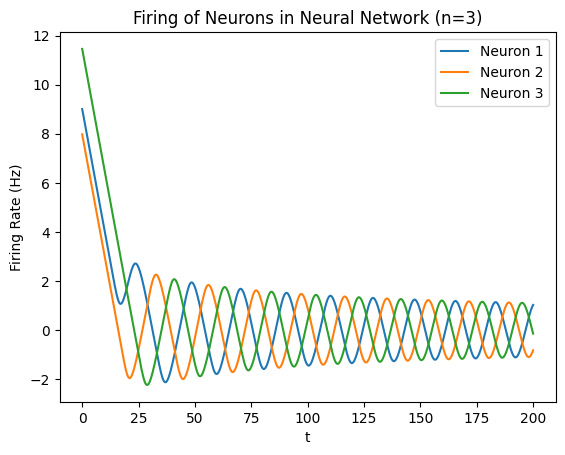

In [11]:
# Plot the simulated behavior of a three neuron neural network
t,y = neuron_ode(W_ring_osc,init_neuron_firing_rate_vector,time_steps,b,t_eval)

# Plot the firing of each neuron in neural network
for i in range(3):
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=3)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

The three neuron neural network was reduced to two neurons and evaluated with the $\textit{neuron\_ode()}$ function over a 200 unit-time interval. <br>
The initial conditions for the system were set as follows,
$$
W = - \begin{pmatrix}
1 & 2 \\
0 & 1
\end{pmatrix}
$$

$$
b = \begin{pmatrix}
0 \\
0
\end{pmatrix}
$$

Random initial conditions were created and the real numbers for the $2x1$ vector were uniformly selected between $0$ and $13$. The range for the random number selection was chosen since the brain primarily generates waves between 0 Hz and 13 Hz. <br><br>

Finally, the ODE solver was set to run for $200$ time steps and evaluate the solution across $2000$ samples between $0$ and $200$ time steps. 

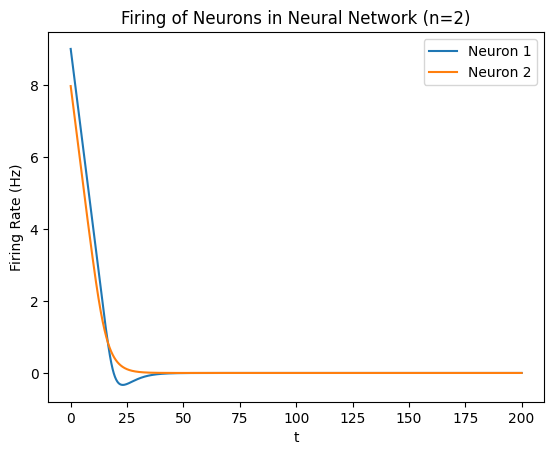

In [12]:
# By reducing the number of neurons from an odd 3 neurons to an even 2 neurons, the two neurons should not oscillate and instead converge to zero as their outputs are dampened

# Plot the simulated behavior of a two neuron neural network
t,y = neuron_ode(W_ring_osc[:2,:2],init_neuron_firing_rate_vector[:2],time_steps,b[:2],t_eval)

# Plot the firing of each neuron in neural network
for i in range(2):  
    plt.plot(t, y[i], label=f"Neuron {i+1}")
plt.title("Firing of Neurons in Neural Network (n=2)")
plt.xlabel("t")
plt.ylabel("Firing Rate (Hz)")
plt.legend()

The directed graph of the odd three neuron network is a good representation of the cyclic design of the ring oscillator. Additionally, the networkx graph edges with weight -2 shows that each neuron is strongly impacted by one neighbor neuron and to a lesser extent itself (-1 weight) when determing whether to fire. The propagation of signal from one neuron to the next can be pictured here as a signal propagates in a ring through each neuron with a similar time varying fire rate for each neuron. 

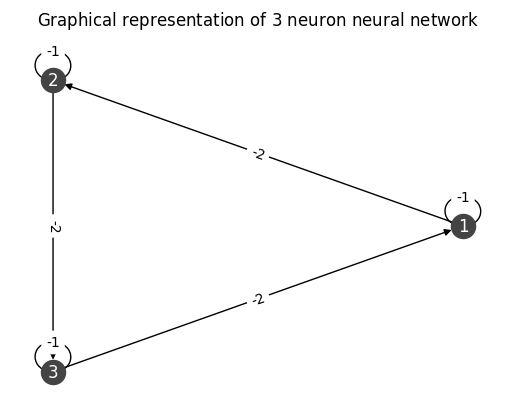

In [13]:
# Graphical representation of 3 neuron neural network based on the weighted connection matrix W

# Create networkX graph variable
G_ring_oscillator = nx.DiGraph()
G_ring_oscillator = gen_nn_nodes(b,G_ring_oscillator)
G_ring_oscillator = gen_nn_edges(W_ring_osc,G_ring_oscillator)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (3))

draw_nn(G_ring_oscillator,ax)

To construct a bistable switch, the system must have both neurons inhibit each other. When one neuron is firing, the other neuron must be supressed. Assuming this behavior, a neuron cannot activate itself because it's activation must be soley dependent on the other neuron in the system. This gives a good intuition on what the weight matrix $W$ may look like.

$$
W = \begin{pmatrix}
0 & -w_2 \\
-w_1 & 0
\end{pmatrix}
$$

Looking at the weight matrix above, neuron $x_1$ and $x_2$ do not activate themselves as represented by the zeroes on the diagonal. Additionally, $w_2$ is an input from neuron $x_2$ to neuron $x_1$, inhibiting the firing of neuron $x_1$. Meanwhile, the weighted input $w_1$ from neuron $x_1$ inhibits neuron $x_2$ from firing. Since the network is bistable, set $w_1$ = $w_2$ so that the two neurons are mutually inhibitory.

For the bias vector, the values will be positive and equal. Positive biases will help lower the activation thresholds of the neurons, meaning a neuron is more likely to fire. If a neuron does not fire in the simulation, then the system may not demonstrate bistability and both neurons may remain inactive. Additionally, the biases will be equal so that both neurons are equally likely to fire during each simulation of the neural network.

$$
b = \begin{pmatrix}
\frac{17}{4} \\
\frac{17}{4}
\end{pmatrix}
$$

Random initial conditions were created and the real numbers for the $2 \times 1$ vector were uniformly selected between $0$ and $13$. The range for the random number selection was chosen since the brain primarily generates waves between 0 Hz and 13 Hz. <br><br>

Finally, the ODE solver was set to run for $200$ time steps and evaluate the solution across $2000$ samples between $0$ and $200$ time steps. 

In [14]:
# Basing initial weighted matrix conditions and activation threshold bias on HW5 bistable switch problem

# Setup initial conditions to model 3 neuron neural network ring oscillator
# Initializing weighted matrix for bistability, using HW5 bistable problem as an example
W_bistable = np.array([
                [0,-0.5],
                [-0.5,0],
])
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing activation bias to be equal, using HW5 bistable problem as an example
b = np.array([17/4,17/4])
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)

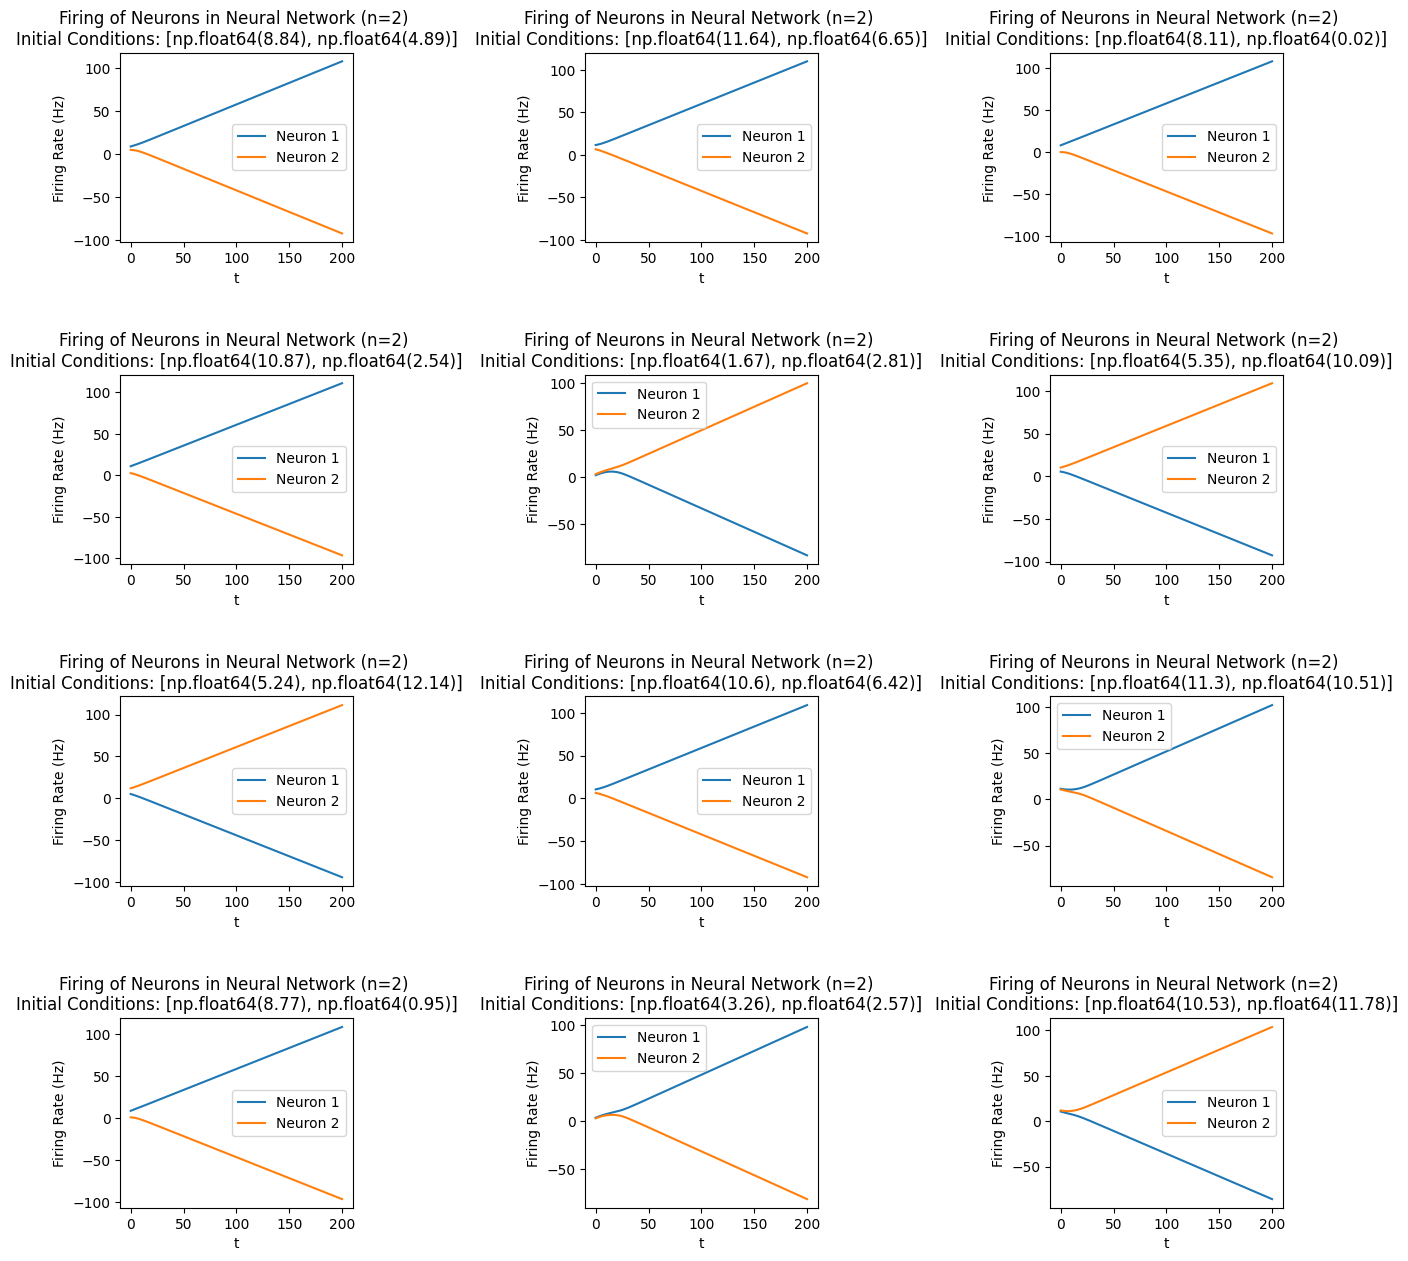

In [15]:
# Generate array of different initial conditions
init_neuron_firing_rate_vector = gen_initial_conditions_array(12,2)

# Generate subplot variable
num_rows = 4
num_cols = 3
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(init_neuron_firing_rate_vector)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_bistable,init_neuron_firing_rate_vector[iter],time_steps,b,t_eval)

    round_initial_conditions = np.round(init_neuron_firing_rate_vector[iter],2)
    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(2):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=2) \nInitial Conditions: {list(round_initial_conditions)}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")
    a.legend()

The directed graph of the two neuron network is a good representation of the bistable neural network. Both neurons inhibit each other with a weighted input of -0.5. Meanwhile, neither neuron activiates itself, so neuron $x_i$'s behavior is soley dependent on neuron $x_j$'s behavior

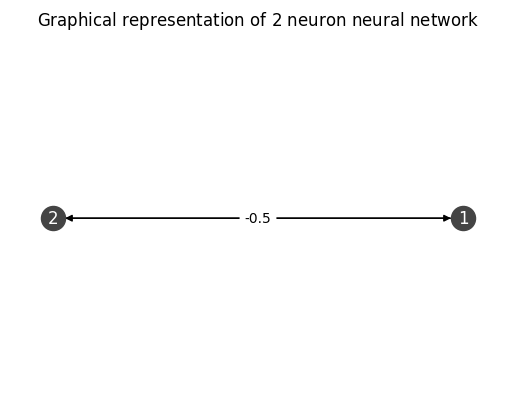

In [16]:
# Graphical representation of bistable neural network based on the weighted connection matrix W

# Create networkX graph variable
G_bistable = nx.DiGraph()
G_stable = gen_nn_nodes(b,G_bistable)
G_stable = gen_nn_edges(W_bistable,G_bistable)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (2))

draw_nn(G_stable,ax)

The approach for the mutually inhibitory oscillator networks was broken into two parts. <br>

1. Looking back at part a), the two neural networks can be treated as two independent ring oscillators. This simplifies the problem because now the mutually inhibitory oscillator networks will need to incorporate the ring oscillator weight matrix and bias vector. Also, breaking up the neural network into two ring oscillators means that both subnetworks will need to contain an odd number of neurons, else no oscillatory behavior will occur from either subnetwork as demonstrated in part a). Using this information, it helps guide the design of the mutually inhibitory oscillator network weight matrix, bias vector, and network size <br><br>

Below is a networkx model, from part a), of how the neuron edges should be connected and weighed in a ring oscillator subnetwork. This model will be duplicated twice for part c) simulation to demonstrate the oscillatory behavior of subnetworks A and B.

![Screenshot 2024-12-12 at 10.49.23 PM.png](<attachment:Screenshot 2024-12-12 at 10.49.23 PM.png>)

2. Looking back at part b), let's simplify the two subnetworks and treat them as two neurons. It is easy to create bistable switches with two neurons since the weight matrix and influence of the bias vector are well known. In a bistable switch, each neuron inhibits the other, meaning that both neurons cannot be "ON" simultaneously. Expanding this to a network level, the two subnetworks will need inihibtory connections between each other, that way when one network oscillates it prevents the other network firing simultaneously. <br> <br>
Making the problem more digestible, there will have to be a neuron pair for each neuron in ring oscillator A to a sister neuron in ring oscillator B. The two sister neurons will inhibit each other. Keeping the neuron pairs $1:1$ prevents unintended excitation/inhibition due to multiple uniquely weighted neuron inputs. Similar to part B and to make the analysis easier, each neuron pair will have equal weight between them so that the two neurons across both networks mutually inhibit each other. Each neuron pair is well represetned by the networkx graph from part b) shown below. <br><br> 

![Screenshot 2024-12-12 at 10.32.37 PM.png](<attachment:Screenshot 2024-12-12 at 10.32.37 PM.png>)

After breaking down the mutually inhibitory oscillator networks problem into two sub-problems that have already been solved, the weight matrix and bias vectors still need to be created. Elaborating on the first subproblem of the solution, the weight matrix will need to represent two subnetworks with the weight matrix from part a). 

$$
W_A, W_B = - \begin{pmatrix}
1 & 2 & 0 \\
0 & 1 & 2 \\
2 & 0 & 1
\end{pmatrix}
$$

To achieve oscillatory behavior, both subnetworks will need an odd number of neurons, so use a neural network consisting of six neurons. Ring oscillator A will be composed of neurons 1,2, and 3. Ring oscillator B will be composed of neurons 4,5, and 6. The networkx graph below shows how the two subnetworks should be represented. <br><br>

![Screenshot 2024-12-12 at 10.57.01 PM.png](<attachment:Screenshot 2024-12-12 at 10.57.01 PM.png>)

To represent a mutually inhibitory bistable switch behavior, there needs to be a neuron pair mapping between neurons and the weights of the neural inputs should be equal. <br> Setting the neuron pair mapping as follows: $$1 \rightleftarrows 4,$$ $$2 \rightleftarrows 5,$$ $$3 \rightleftarrows 6$$ 

Putting all this together, the weight matrix $W$ for part $c$ should look like,
$$
W = - \begin{pmatrix}
1 & 2 & 0 & 0.5 & 0 & 0 \\
0 & 1 & 2 & 0 & 0.5 & 0 \\
2 & 0 & 1 & 0 & 0 & 0.5 \\
0.5 & 0 & 0 & 1 & 2 & 0 \\
0 & 0.5 & 0 & 0 & 1 & 2 \\
0 & 0 & 0.5 & 2 & 0 & 1
\end{pmatrix}
$$

The actual weight values are carry-over from parts $a$ and $b$, and after running the simulation I did not see a need to change the values.

The bias vector $b$ is less consequential. Similar to part $b$, the biases were all set to zero since the circuit guarantees oscillatory behavior so there's no need to bias the neurons to become more excited or inhibit them.

$$
b = \begin{pmatrix}
0 \\
0 \\
0 \\
0 \\
0 \\
0
\end{pmatrix}
$$

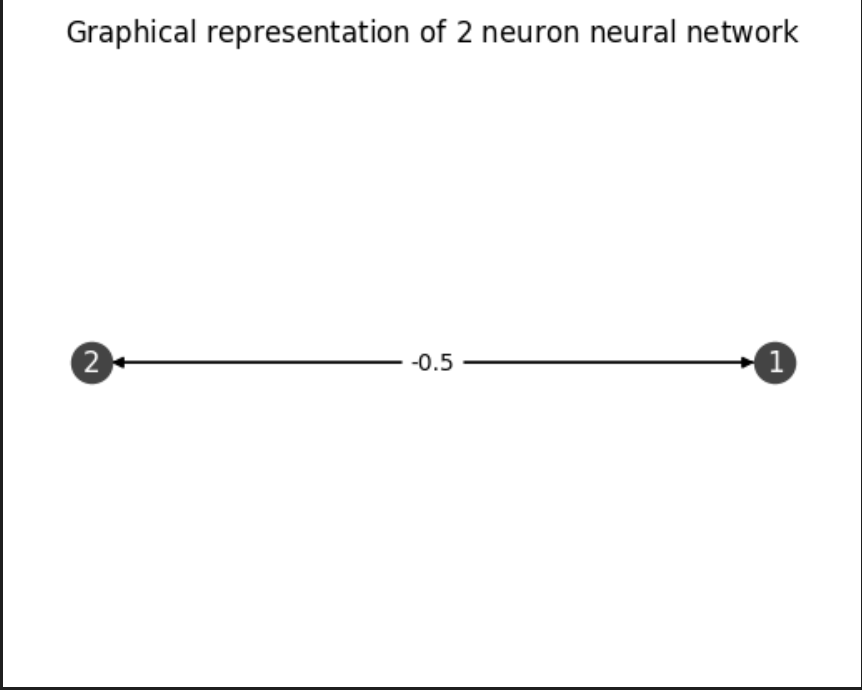
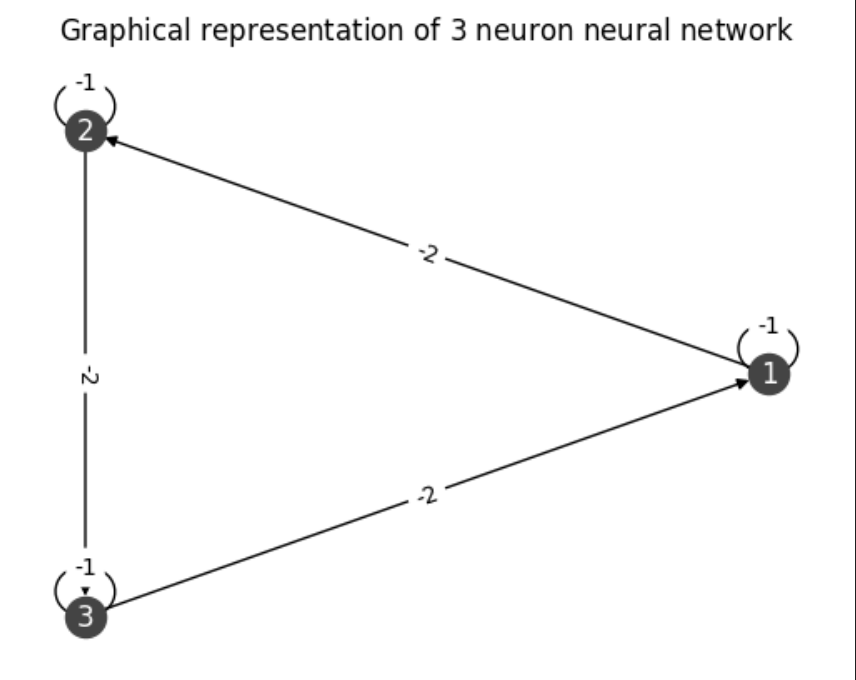
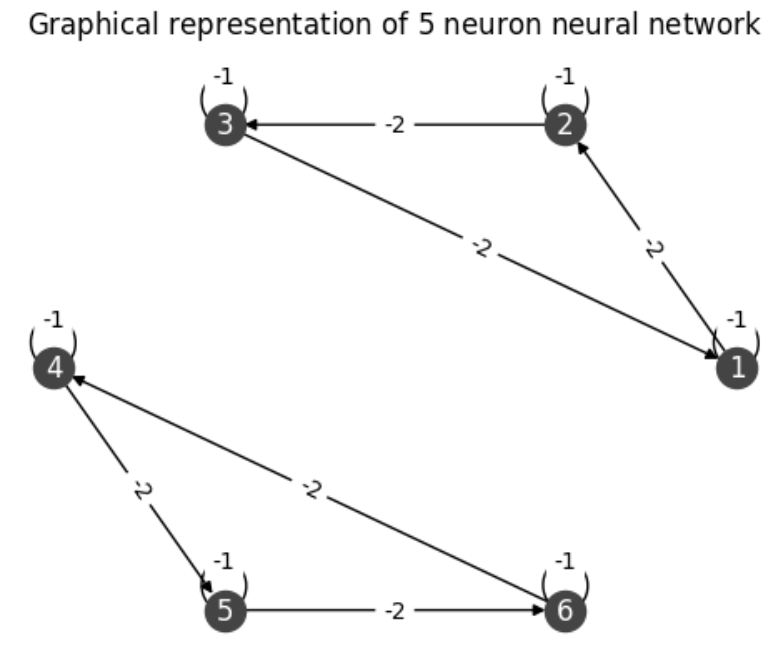

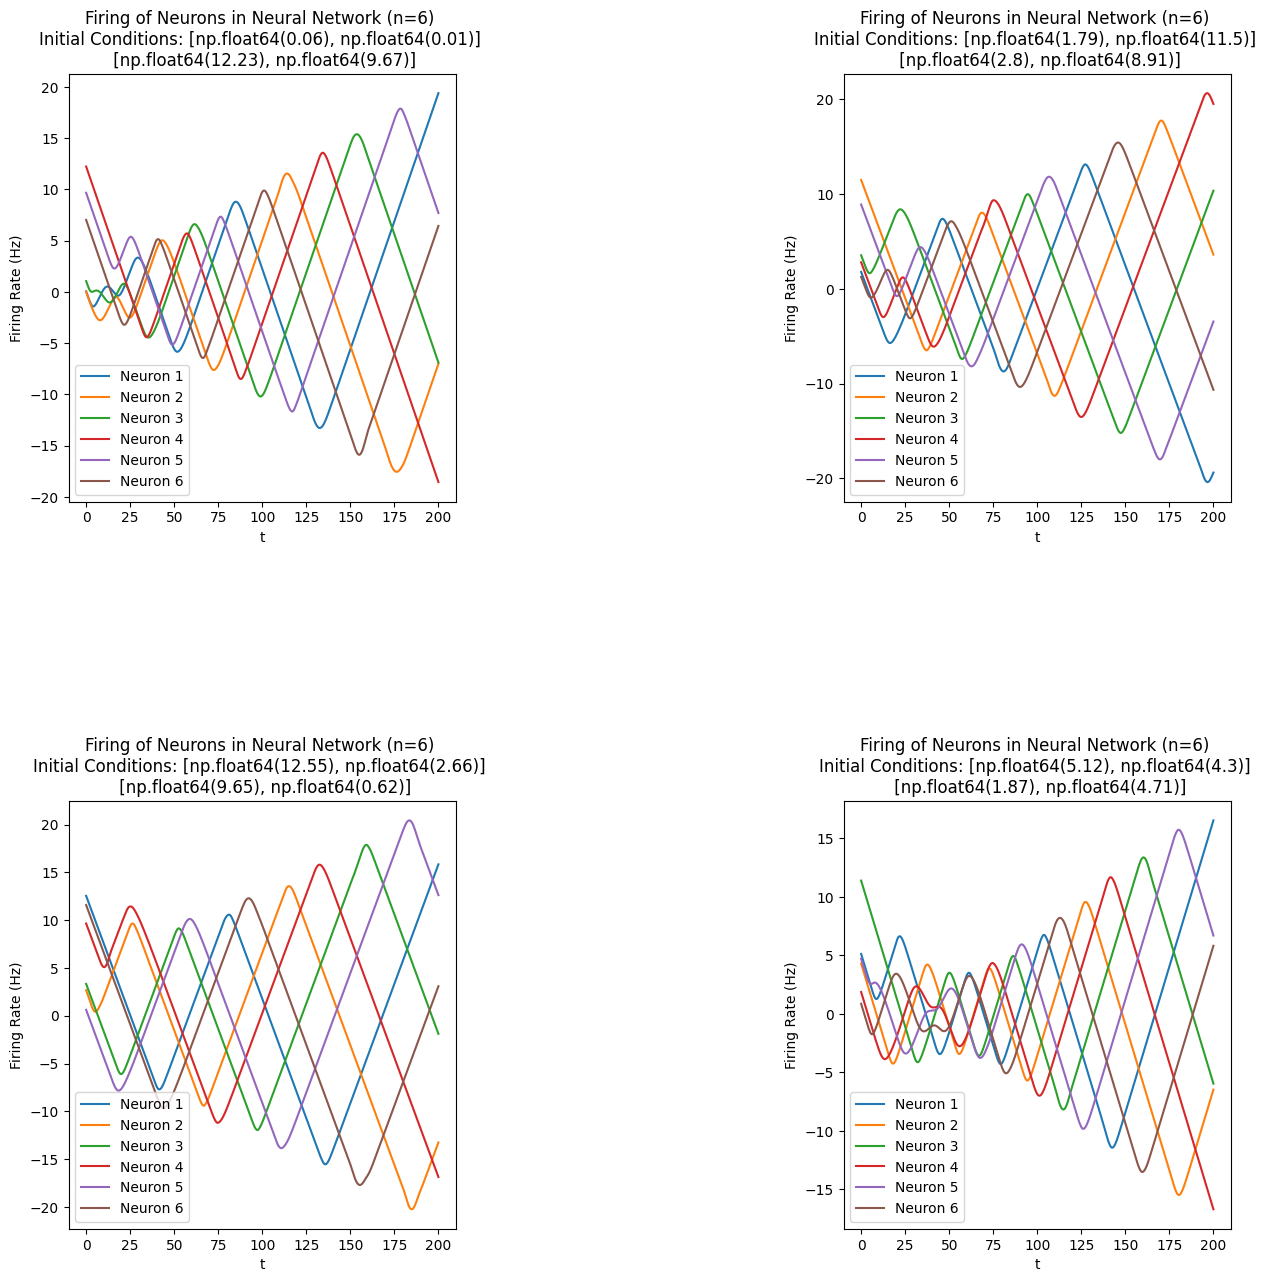

In [23]:
# Simulate a n-size neuron neural network that is bistable, where the "on" neurons oscillate and supress the "off" neurons

num_neurons = 6
num_initial_conditions = 4
# Initializing weighted matrix for bistability and oscillation
W_bistable_multivibrator = np.array([
                                    [1,2,0,0.5,0,0],
                                    [0,1,2,0,0.5,0],
                                    [2,0,1,0,0,0.5],
                                    [0.5,0,0,1,2,0],
                                    [0,0.5,0,0,1,2],
                                    [0,0,0.5,2,0,1]
                                    ])
W_bistable_multivibrator = -W_bistable_multivibrator

# Initializing activation bias
b = np.zeros(num_neurons)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
# Generate array of different initial conditions
init_neuron_firing_rate_vector = gen_initial_conditions_array(num_initial_conditions,num_neurons)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 2000)

# Generate subplot variable
num_rows = 2
num_cols = 2
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(init_neuron_firing_rate_vector)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_bistable_multivibrator,init_neuron_firing_rate_vector[iter],time_steps,b,t_eval)

    round_initial_conditions = np.round(init_neuron_firing_rate_vector[iter],2)
    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(num_neurons):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=6) \nInitial Conditions: {list(round_initial_conditions[0:2])} \n {list(round_initial_conditions[3:5])}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")
    a.legend()

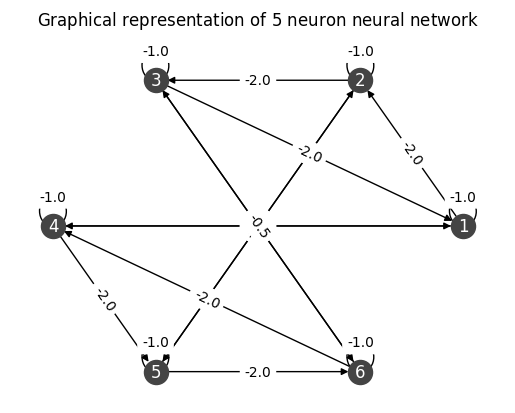

In [24]:
# Graphical representation of bistable multivibrator neural network based on the weighted connection matrix W

# Create networkX graph variable
G_bistable_multivibrator = nx.DiGraph()
G_bistable_multivibrator = gen_nn_nodes(b,G_bistable_multivibrator)
G_bistable_multivibrator = gen_nn_edges(W_bistable_multivibrator,G_bistable_multivibrator)

# Create graph
basic_graph,ax = plt.subplots(1,1)
ax.set_title("Graphical representation of $%d$ neuron neural network" % (5))

draw_nn(G_bistable_multivibrator,ax)

For this last problem, a random weight matrix is generated, and more importantly the network moves from a sparse neural network to a dense neural network. For this approach, each iteration of the run increased the value of $p$, which was the threshold value for determining whether an edge exists between two neurons. Regardless of the value of $p$, the random variable was uniformly selected at random in the range $[0,1]$, so the weight had an equal chance of becoming $1$ or $-1$. 

Random initial conditions were created and the real numbers for the $2x1$ vector were uniformly selected between $0$ and $13$. The range for the random number selection was chosen since the brain primarily generates waves between 0 Hz and 13 Hz. <br><br>

Finally, the ODE solver was set to run for $200$ time steps and evaluate the solution across $2000$ samples between $0$ and $200$ time steps. 

In [19]:
# Random Neural Network with 50 neurons
n = 50
p = 0.5
lower_bound = 0
upper_bound = 1
rand_weight_matrix = gen_rand_weight_matrix(n,p,lower_bound,upper_bound)
W = sub_identity_matrix(n,rand_weight_matrix)
print(W)

[[-1. -1.  0. ...  0. -1. -1.]
 [ 1.  0. -1. ... -1.  0.  1.]
 [ 0.  0. -1. ... -1.  1. -1.]
 ...
 [ 0.  0.  1. ... -1.  0.  0.]
 [-1. -1.  0. ...  1. -1.  0.]
 [ 0. -1.  1. ... -1.  1. -2.]]


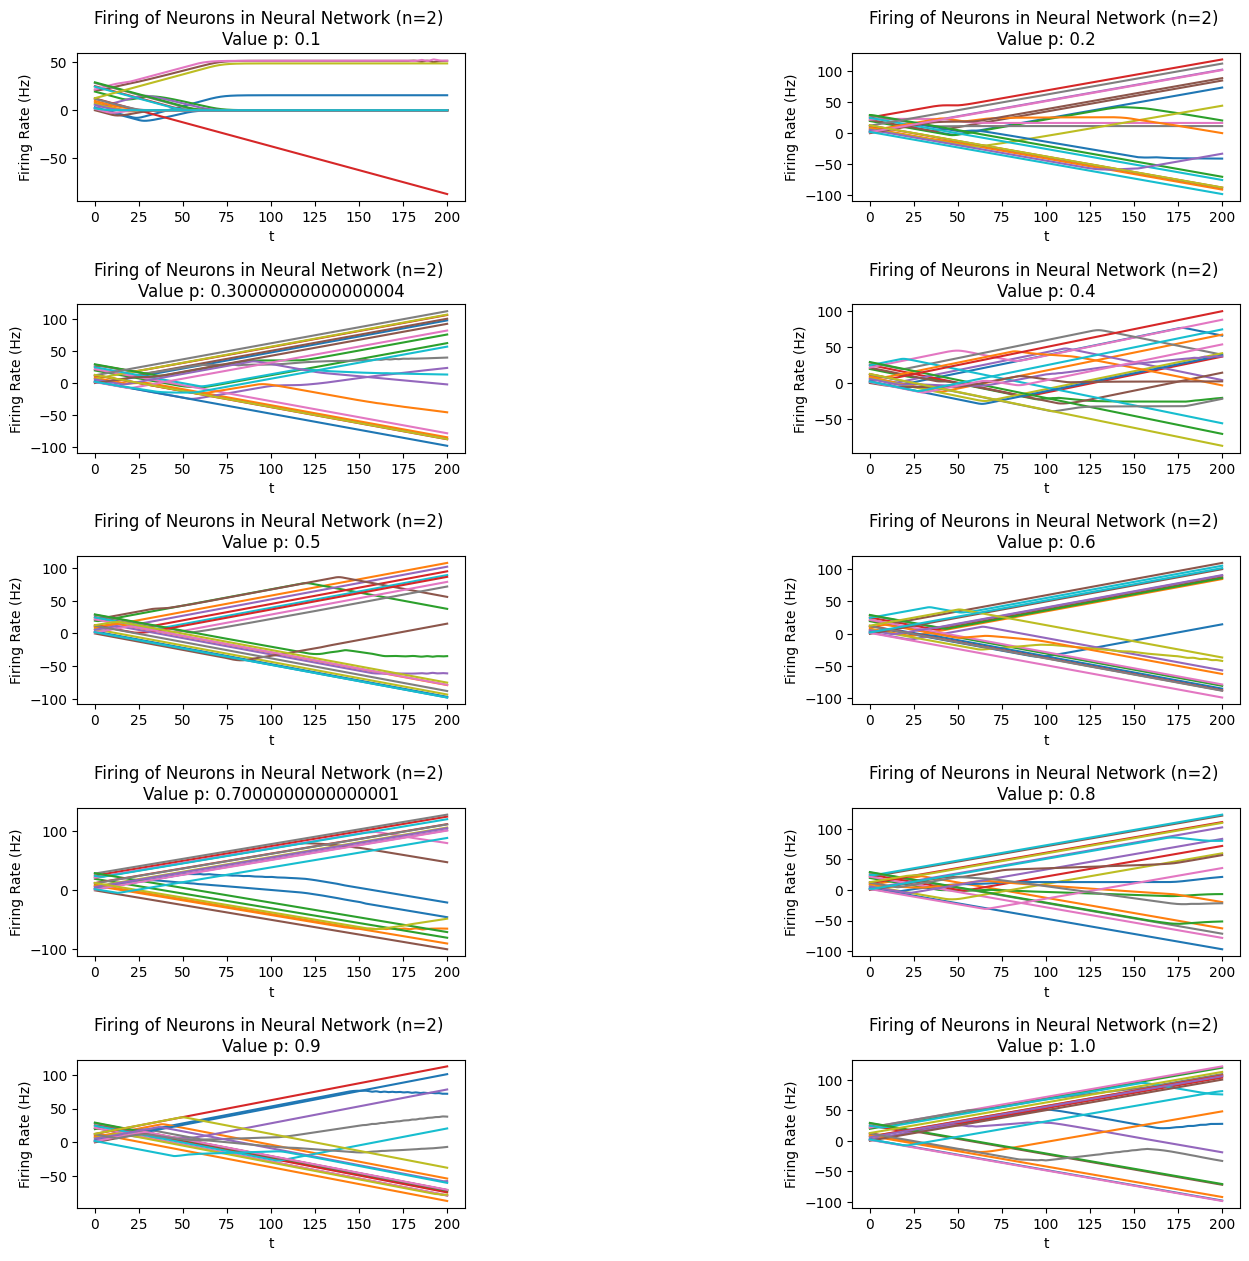

In [20]:
# Simulate 20-neuron neural network with various random adjancency matrices by changing the value p
# Set initial conditons to generate random weight matrices
p = np.linspace(0.1, 1, 10)
n = 20
lower_bound = 0
upper_bound = 1
W_p = []

# Initializing activation bias
b = np.zeros(n)
# Setting timestep range for ODE func
time_steps = [0,200]
# Initializing neuron firing rates for all neurons in the neural network to a random real number between 0 Hz and 13 Hz. 
# This range appears to be a reasonable neural firing rates for alpha,delta,theta,and beta brain waves
# The animal is not specified, but assuming brain activity observations are on humans, based on the surronding article context.
# Wikipedia. [Neural oscillation]. Wikipedia. [Online]. Available: https://en.wikipedia.org/wiki/Neural_oscillation (Accessed: Dec. 7, 2024).
init_neuron_firing_rate_vector = np.array([random.uniform(0,30) for i in range(n)]).reshape(n,)
# Setting up evaluation points for ODE func
t_eval = np.linspace(0, 200, 1000)

# Generate weight matrices
for i in range(len(p)):
    rand_weight_matrix = gen_rand_weight_matrix(n,p[i],lower_bound,upper_bound)
    W_p.append(sub_identity_matrix(n,rand_weight_matrix))

# Generate subplot variable
num_rows = 5
num_cols = 2
fig,xn = plt.subplots(num_rows,num_cols,figsize=(15,15))
plt.subplots_adjust(wspace=1, hspace=0.7)

for iter in range(len(p)):
    # Plot the simulated behavior of a three neuron neural network
    t,y = neuron_ode(W_p[iter],init_neuron_firing_rate_vector,time_steps,b,t_eval)

    a = xn[int(iter/num_cols), iter%num_cols]
    # Plot the firing of each neuron in neural network
    for i in range(n):
        a.plot(t, y[i], label=f"Neuron {i+1}")
    a.set_title(f"Firing of Neurons in Neural Network (n=2) \nValue p: {p[iter]}")
    a.set_xlabel("t")
    a.set_ylabel("Firing Rate (Hz)")